In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import numpy as np
import tensorflow as tf
import os.path as osp
import matplotlib.pylab as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from collections import defaultdict

In [3]:
from tflearn.layers.core import fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry_new, decoder_with_fc_only
from tf_lab.fundamentals.inspect import count_trainable_parameters

In [4]:
from general_tools.notebook.tf import reset_tf_graph
from geo_tool import Point_Cloud, Mesh
from helper import plot_mesh, load_diff_maps, load_pclouds_of_shapes,\
pose_labels_and_original_index, load_gt_latent_params, load_meshes,\
make_data, prepare_train_test_val, load_pclouds_of_shapes

In [5]:
from scipy.io import loadmat, savemat

In [7]:
def pc_net(n_pc_points):
    with tf.variable_scope('pc_based_net') as scope:
        feed_pl = tf.placeholder(tf.float32, shape = (None, n_pc_points, 3) )
        labels_pl = tf.placeholder(tf.int64, shape=[None])                           
        layer = encoder_with_convs_and_symmetry_new(feed_pl, n_filters=[64, 128], b_norm=False)
        layer = fully_connected(layer, 64, activation='relu', weights_init='xavier')
        logits = fully_connected(layer, n_classes, activation='linear', weights_init='xavier')
    return feed_pl, labels_pl, logits

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib nbagg

In [13]:
top_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/human_poses/'
top_mesh_dir = '/orions4-zfs/projects/optas/DATA/Meshes/SCAPE_8_poses_Ananth/'

In [14]:
n_shapes = 2000
mesh_ids = np.arange(1, n_shapes+1)
in_meshes = load_meshes(mesh_ids)

In [82]:
n_pc_points = 1024

In [83]:
uniform_pcs = np.zeros(shape =(n_shapes, n_pc_points, 3))
for i, m in enumerate(in_meshes):
    uniform_pcs[i] = m.sample_faces(n_pc_points)[0]

In [21]:
gt_latent_params = load_gt_latent_params(top_data_dir)

In [84]:
seed = 42
val_per = 0.10
test_per = 0.15
train_per = 1.0 - (val_per + test_per)

['feed', 'labels', 'ids']
['feed', 'labels', 'ids']
['feed', 'labels', 'ids']


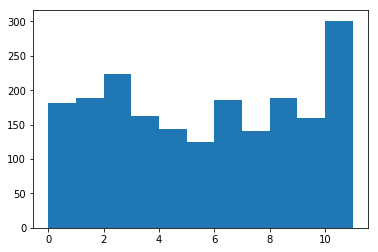

In [85]:
n_classes = 12
unsup_clf = KMeans(n_clusters=n_classes, random_state=seed)
in_labels = unsup_clf.fit_predict(gt_latent_params)
plt.hist(in_labels, bins=np.arange(n_classes))
splits = prepare_train_test_val(n_shapes, in_labels, train_per, test_per, seed=seed)
in_data = make_data(splits, uniform_pcs, in_labels)

In [86]:
reset_tf_graph()
feed_pl, labels_pl, logits = pc_net(n_pc_points)
print count_trainable_parameters()

17612


In [87]:
learning_rate = 0.005
batch_size = 50
n_epochs = 500

In [94]:
prediction = tf.argmax(logits, axis=1)
target_ = labels_pl
correct_pred = tf.equal(prediction, target_)
avg_accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
one_hot_labels = tf.one_hot(labels_pl, depth=n_classes)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_labels)
loss = tf.reduce_mean(cross_entropy)

opt = tf.train.AdamOptimizer(learning_rate)
opt_step = opt.minimize(loss)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init=tf.global_variables_initializer()
sess.run(init)

In [95]:
train_losses = []
val_losses = []
test_losses = []

train_data = in_data['train']
val_data = in_data['val']
test_data = in_data['test']

batches_for_epoch = train_data.n_examples / batch_size
train_res = defaultdict(list)
loss_res = defaultdict(list)

In [96]:
for epoch in range(n_epochs):
    for _ in range(batches_for_epoch):        
        batch_d, batch_l, _ = train_data.next_batch(batch_size)
        feed_dict = {feed_pl:batch_d, labels_pl:batch_l}
        sess.run([opt_step, loss, avg_accuracy], feed_dict=feed_dict)
    
    print epoch,
    
    for s in ['train', 'test', 'val']:
        feed_dict = {feed_pl:in_data[s].feed, labels_pl:in_data[s].labels}
        r, l = sess.run([avg_accuracy, loss], feed_dict=feed_dict)
        train_res[s].append(r)
        loss_res[s].append(l)
        print r,
    print

0 0.127333 0.113333 0.11
1 0.111333 0.103333 0.12
2 0.169333 0.17 0.155
3 0.218667 0.193333 0.19
4 0.150667 0.12 0.125
5 0.208 0.206667 0.2
6 0.21 0.206667 0.175
7 0.254 0.226667 0.21
8 0.248 0.24 0.175
9 0.248 0.243333 0.215
10 0.225333 0.213333 0.235
11 0.234667 0.203333 0.19
12 0.263333 0.24 0.19
13 0.269333 0.266667 0.205
14 0.238 0.236667 0.205
15 0.254 0.233333 0.205
16 0.309333 0.27 0.19
17 0.283333 0.236667 0.195
18 0.256 0.233333 0.235
19 0.294 0.266667 0.23
20 0.301333 0.286667 0.235
21 0.328667 0.293333 0.275
22 0.362 0.38 0.31
23 0.408667 0.376667 0.345
24 0.355333 0.346667 0.295
25 0.379333 0.38 0.335
26 0.330667 0.303333 0.31
27 0.416667 0.416667 0.42
28 0.403333 0.39 0.365
29 0.389333 0.37 0.375
30 0.411333 0.406667 0.395
31 0.425333 0.43 0.42
32 0.436667 0.436667 0.435
33 0.419333 0.393333 0.4
34 0.426 0.373333 0.42
35 0.440667 0.403333 0.425
36 0.446 0.413333 0.44
37 0.415333 0.373333 0.425
38 0.42 0.39 0.405
39 0.438667 0.436667 0.435
40 0.439333 0.406667 0.405
41 0.4

1


0.81453329

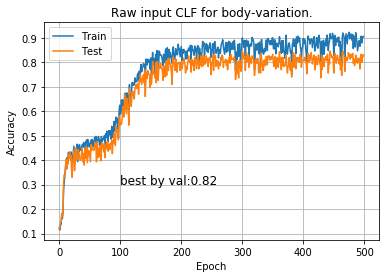

In [69]:
plt.plot(train_res['train'])
plt.plot(train_res['test'])
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

title_tag = 'Raw input'

plt.title('%s CLF for body-variation.'% (title_tag, ))

val_maximizers = np.where(train_res['val'] == np.max(train_res['val']))[0]
val_best = np.mean(np.array(train_res['test'])[val_maximizers])
plt.text(100, 0.3, 'best by val:%.2f' % (val_best,), fontsize=12);
print len(val_maximizers)
np.mean(np.array(train_res['test'])[int(n_epochs - n_epochs*0.05):])